# CART POLE

In [1]:
import gymnasium as gym

In [2]:
env = gym.make("CartPole-v1")
print(env)

<TimeLimit<OrderEnforcing<PassiveEnvChecker<CartPoleEnv<CartPole-v1>>>>>


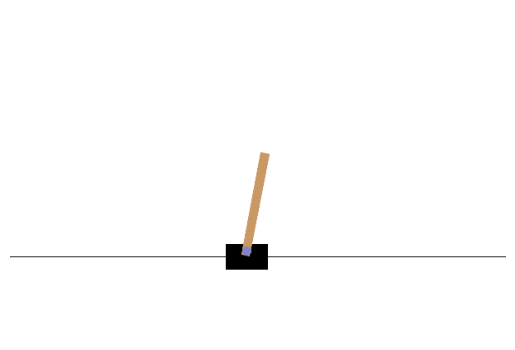

Step: 17 Reward: 1.0 Total: 18.0
this is obvs =  [-0.13122976 -1.1709685   0.2242337   1.9700726 ]
this is info =  {}

FINAL TOTAL REWARD: 18.0


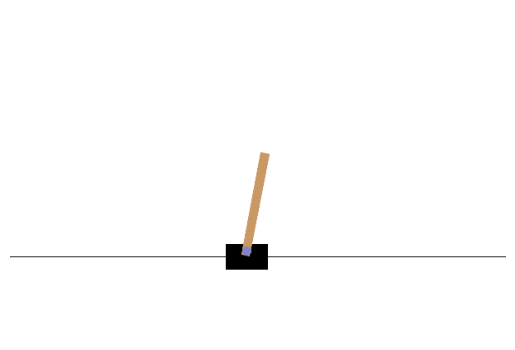

In [7]:
import gymnasium as gym
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import time

env = gym.make("CartPole-v1", render_mode="rgb_array")

obs, info = env.reset(seed=100)


done = False

plt.ion()
fig, ax = plt.subplots()

step = 0
total_reward = 0   # 🔥 reward track karne ke liye variable

while not done and step < 300:
    frame = env.render()
    ax.imshow(frame)
    ax.axis("off")

    clear_output(wait=True)
    display(fig)

    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)

    total_reward += reward    # 🔥 reward add

    print("Step:", step, "Reward:", reward, "Total:", total_reward)

    done = terminated or truncated
    step += 1

    time.sleep(0.03)

env.close()
plt.ioff()


print("this is obvs = ",obs)
print("this is info = ",info)
print("\nFINAL TOTAL REWARD:", total_reward)


# MonteCarlo

In [ ]:
import gymnasium as gym
import numpy as np
import random


def rollout_from_state(base_state, first_action, max_steps=200):
    """
    Ek state se start karke:
    - pehle given action lagao
    - phir random actions se episode khatam hone tak chalao
    - total reward return karo
    """
    # Naya env banao (simulator copy)
    env_sim = gym.make("CartPole-v1")
    obs, info = env_sim.reset()

    # CartPoleEnv ke andar "state" naam ka internal variable hota hai
    # Jise hum manually override kar rahe hain (educational hack)
    env_sim.unwrapped.state = np.array(base_state, dtype=np.float32)

    total_reward = 0.0

    # Pehla action jo MCTS test karna chahta hai
    obs, reward, terminated, truncated, info = env_sim.step(first_action)
    total_reward += reward
    done = terminated or truncated

    steps = 1

    # Ab future ko random actions se simulate karo
    while not done and steps < max_steps:
        a = random.choice([0, 1])  # random left/right
        obs, reward, terminated, truncated, info = env_sim.step(a)
        total_reward += reward
        done = terminated or truncated
        steps += 1

    env_sim.close()
    return total_reward


def mcts_action(env, current_obs, n_rollouts_per_action=20, max_steps_per_rollout=200):
    """
    Simple MCTS-style decision:
    - Dono actions (0, 1) ke liye multiple rollouts chalao
    - Average reward compare karo
    - Jiska average reward zyada, woh action choose karo
    """
    base_state = env.unwrapped.state.copy()

    action_values = {}
    for action in [0, 1]:
        rewards = []
        for _ in range(n_rollouts_per_action):
            r = rollout_from_state(
                base_state,
                first_action=action,
                max_steps=max_steps_per_rollout,
            )
            rewards.append(r)

        action_values[action] = np.mean(rewards)

    # Best action choose karo (highest average reward)
    best_action = max(action_values, key=action_values.get)
    return best_action, action_values


def run_mcts_cartpole(num_episodes=5):
    env = gym.make("CartPole-v1")
    all_episode_rewards = []

    for ep in range(num_episodes):
        obs, info = env.reset(seed=ep)
        done = False
        total_reward = 0.0
        step = 0

        print(f"\n=== Episode {ep + 1} ===")

        while not done:
            # Yahan MCTS se action choose ho raha hai
            action, action_values = mcts_action(env, obs)

            # Debug print (optional)
            print(
                f"Step {step:3d} | "
                f"Q(0)~{action_values[0]:6.1f}, Q(1)~{action_values[1]:6.1f} "
                f"=> action = {action}"
            )

            obs, reward, terminated, truncated, info = env.step(action)
            total_reward += reward
            done = terminated or truncated
            step += 1

        all_episode_rewards.append(total_reward)
        print(f"Episode {ep + 1} finished, total reward = {total_reward}")

    env.close()
    print("\nAll episode rewards:", all_episode_rewards)
    print("Average reward:", np.mean(all_episode_rewards))


if __name__ == "__main__":
    run_mcts_cartpole(num_episodes=3)


# JAX VMAP

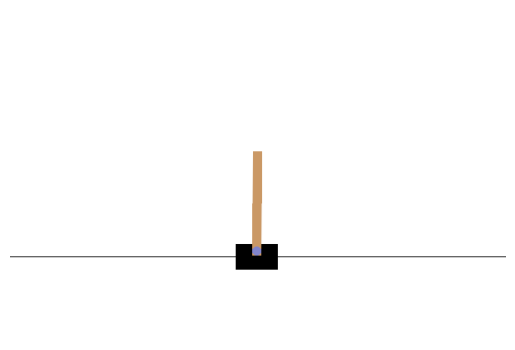

Step=32 | Rewards=[0. 0. 0. 0. 0. 1. 0. 0.] | Total=[18. 22. 23. 14. 29. 33. 13. 22.]

=== FINAL TOTAL REWARD (per env) ===
[18. 22. 23. 14. 29. 33. 13. 22.]


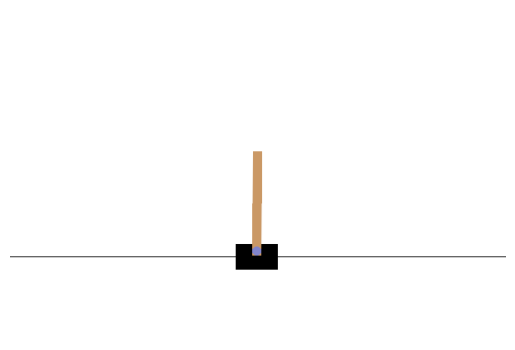

In [7]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import time

# === Create Vectorized Environment ===
num_envs = 8
envs = gym.make_vec("CartPole-v1", num_envs=8, render_mode="rgb_array")

obs, info = envs.reset(seed=0)
dones = np.array([False] * num_envs)

# === Track rewards for each env ===
total_rewards = np.zeros(num_envs)

plt.ion()
fig, ax = plt.subplots()

step = 0

while not np.all(dones) and step < 300:

    # Render only the FIRST environment for display
    frame = envs.render()[0]   # shape: (num_envs, H, W, 3)
    ax.imshow(frame)
    ax.axis("off")
    clear_output(wait=True)
    display(fig)

    # Vectorized random actions
    actions = np.random.randint(0, 2, size=(num_envs,))

    obs, rewards, terminated, truncated, info = envs.step(actions)

    # Add reward only for envs that aren't done
    rewards = np.where(dones, 0, rewards)
    total_rewards += rewards

    # Update done flags
    dones = np.logical_or(dones, np.logical_or(terminated, truncated))

    # Debug print
    print(f"Step={step} | Rewards={rewards} | Total={total_rewards}")

    step += 1
    time.sleep(0.03)

envs.close()
plt.ioff()

print("\n=== FINAL TOTAL REWARD (per env) ===")
print(total_rewards)
